<a href="https://colab.research.google.com/github/jun981015/torch-implementation/blob/main/vision/VIT/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# VIT

In [ ]:
# !pip install einops
import torch
import torch.nn as nn
from torchsummary import summary
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from typing import Any,Callable,Tuple
import tqdm

In [2]:
vit_config = {
    "user" :
        {"num_layers" : 7, "embed_dim"  : 384, "mlp_dim" : 384, "num_heads" : 12},
    "base" :
        {"num_layers" : 12, "embed_dim"  : 768, "mlp_dim" : 3072, "num_heads" : 12},
    "large" :
        {"num_layers" : 24, "embed_dim"  : 1024, "mlp_dim" : 4096, "num_heads" : 16},
    "huge" :
        {"num_layers" : 32, "embed_dim"  : 1280, "mlp_dim" : 5120, "num_heads" : 16}
}

In [3]:
class Patch2Vector(nn.Module):
    def __init__ (self, patch_size, channel, embed_dim, num_patches, embed_type = 'conv', ):
        super().__init__()
        if embed_type =='conv':
            self.projection = nn.Sequential(
                nn.Conv2d(channel, embed_dim, kernel_size=patch_size, stride=patch_size),
                Rearrange('batch (embed_dim) h w -> batch (h w) embed_dim')
            )
        elif embed_type == 'flatten': #proposed method in original VIT
            self.projection = nn.Sequential(
                Rearrange('batch c (h p1) (w p2) -> batch (h w) (p1 p2)', p1 = patch_size, p2 = patch_size),
                nn.Linear(patch_size**2*channel, embed_dim),
            )
        else :
            raise NotImplementedError("embed_type only 'conv' or flat ")
        self.cls_token= nn.Parameter(torch.randn(1, 1, embed_dim)) #shape (1, 1, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(num_patches + 1, embed_dim)) #shape (num_patches+1, embed_dim)
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.projection(x)# b,c,h,w -> b (h*w)/p^2 c*p^2 : batch num_patches embed_dim
        batch = x.shape[0]
        x_cls = repeat(self.cls_token, '1 1 e -> b 1 e', b=batch)
        embedding = torch.cat((x_cls, x), dim=1) + self.pos_embedding # b n+1 e. add cls_token
        return embedding

In [4]:
class MultiheadSelfAtteintion(nn.Module):
    def __init__(self, embed_dim, num_heads, drop_out):
        super().__init__()
        self.num_heads = num_heads
        assert embed_dim%num_heads == 0, f'embed_dim must can be divisible by num_heads,{embed_dim} can not bivided by {num_heads}'
        self.scaling = (embed_dim//num_heads)**-0.5

        self.qkv = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*3),
            Rearrange('b n (qkv d) -> qkv b n d' , qkv = 3),
            Rearrange('qkv b n (h d) -> qkv b h n d', h = num_heads)
            )
        self.dropout = nn.Dropout(drop_out)
        self.o = nn.Linear(embed_dim, embed_dim)
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        q, k, v= self.qkv(x) #b h n d

        att_score = torch.matmul(q,k.transpose(-2,-1))*self.scaling # [b h (n d)]@[b h (d n)] -> b h n n, @ is mat mul
        att_score = torch.softmax(att_score, dim = -1)
        att_score = self.dropout(att_score)
        att = torch.matmul(att_score, v) # [b h (n n)] @ [b h (n d)] -> b h n d
        att = rearrange(att, 'b h n d -> b n (h d)')

        return self.o(att)

In [5]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, mlp_dim, drop_out):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(drop_out),
            nn.Linear(mlp_dim,embed_dim),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.ff(x)

In [6]:
class EncoderBlock(nn.ModuleList):
    def __init__(self, embed_dim, mlp_dim, num_heads, drop_out):
        super().__init__()
        self.MSA = nn.Sequential(
            nn.LayerNorm(embed_dim),
            MultiheadSelfAtteintion(embed_dim, num_heads, drop_out),
            )
        self.FF = nn.Sequential(
            nn.LayerNorm(embed_dim),
            FeedForward(embed_dim, mlp_dim, drop_out),
        )
        self.dropout = nn.Dropout(drop_out)
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.MSA(x) + x
        x = self.dropout(x)
        x = self.FF(x) + x
        x = self.dropout(x)
        x = self.norm(x)
        return x

In [7]:
class VIT(nn.Module):
    def __init__(self,  image_size : Tuple[int, int, int] = (3, 224, 224), patch_size : int = 16, num_classes : int = 1000, embed_type :str = 'conv', vit_type :str = 'base' ,pred_type : str = 'mean', dropout = 0., embed_dropout = 0.):
        super().__init__()
        assert vit_type in ('user','base', 'large', 'huge'), f"vit_type must be 'usser' or 'base' or 'large' or 'huge'. but {vit_type}"
        assert pred_type in ('mean', 'cls_token'), f"pred_type must be 'mean' or 'cls_token'. but {pred_type}"
        self.pred_type = pred_type
        self.num_classes = num_classes
        self.channel , self.height,self.width = image_size
        assert not (self.height%patch_size or self.width%patch_size)  , f"image size must be divisible by patch size,({self.height},{self.width}) can't devide by {patch_size} "
        self.num_patches = (self.height*self.width)//patch_size**2
        self.patch_size = patch_size
        self.config = vit_config[vit_type]
        for k, v in self.config.items(): setattr(self, k, v)

        self.att_dropout_ratio = dropout
        self.embed_dropout_ratio = embed_dropout

        # assert self.embed_dim==self.patch_size**2*self.channel, f"embed dimension of VIT-{vit_type} : {self.embed_dim}. but {self.patch_size**2*self.channel} "
        ###patch embedding
        self.patch2vec = Patch2Vector(patch_size,self.channel, self.embed_dim, self.num_patches, embed_type)
        self.embed_dropout = nn.Dropout(embed_dropout)
        ###Tansformer Encoder
        self.encoders = nn.ModuleList([EncoderBlock(self.embed_dim, self.mlp_dim, self.num_heads, dropout) for _ in range(self.num_layers)])
        ###classifier
        self.classifier = nn.Linear(self.embed_dim, num_classes)
    def forward(self,x : torch.Tensor) -> torch.Tensor:
        """
        x : (batch, channel, height, width)
        """
        if len(x.shape)==4:
            pass
        elif len(x.shape)==3:
            x = x.unsqueeze(dim=0)
        else :
            raise ValueError(f"input dimension only allowed by (batch, channel, height, width) or (channel, height, width) but {x.shape}")
        assert x.shape[-2]==self.height and x.shape[-1]==self.width, f"expected height and width are {(self.height, self.width)} but {x.shape}"
        x = self.patch2vec(x)
        x = self.embed_dropout(x) #batch num_patches+1 embed_dim

        for encoder in self.encoders:
            x = encoder(x)+x#batch num_patches+1 embed_dim
        x = x.mean(dim=1) if self.pred_type=='mean' else x[:,0] # b n+1 e -> b e
        #class token을 이용해 예측하는 경우 b n e 중 n의 첫번째에 해당하는 벡터이므로 이를 이용, 평균을 이용하는 경우 n에 대한 평균
        '''
        Both during pre-training and fine-tuning, a classification head is attached to z^0_L
        The classification head is implemented by a MLP with one hidden layer at pre-training
        time and by a single linear layer at fine-tuning time.
        '''
        return self.classifier(x)

In [14]:
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor,Compose,Normalize
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import random, os
import numpy as np
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [24]:
train_transform= Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(degrees=(-15,15), translate=(0.1, 0.1), scale=(0.9, 1.1)) ,
     transforms.RandomCrop(32,padding = 4),
     ToTensor(),
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])
test_transform  = Compose(
    [
     transforms.ToTensor(),
     Normalize((0.491, 0.482 ,0.447), (0.247, 0.243, 0.262))
     ])
CIFAR10 = 1
if CIFAR10:
    num_classes = 10
    train_set = datasets.CIFAR10(root='./data/',train=True,download=True,transform = train_transform)
    test_set = datasets.CIFAR10(root='./data/',train=False,download=True,transform = test_transform)
else:
    num_classes = 100
    train_set = datasets.CIFAR100(root='./data/',train=True,download=True,transform = train_transform)
    test_set = datasets.CIFAR100(root='./data/',train=False,download=True,transform = test_transform)
model = VIT(image_size=(3,32,32), patch_size=4, num_classes = num_classes,vit_type='user' ,pred_type = 'cls_token', embed_type = 'conv', embed_dropout=0.,dropout=0.)
print(train_set)
print(test_set)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-15.0, 15.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.491, 0.482, 0.447), std=(0.247, 0.243, 0.262))
           )


In [25]:
summary(model, (3,32,32),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 384, 8, 8]          18,816
         Rearrange-2              [-1, 64, 384]               0
      Patch2Vector-3              [-1, 65, 384]               0
           Dropout-4              [-1, 65, 384]               0
         LayerNorm-5              [-1, 65, 384]             768
            Linear-6             [-1, 65, 1152]         443,520
         Rearrange-7           [-1, 2, 65, 384]               0
         Rearrange-8        [-1, 2, 12, 65, 32]               0
           Dropout-9           [-1, 12, 65, 65]               0
           Linear-10              [-1, 65, 384]         147,840
MultiheadSelfAtteintion-11              [-1, 65, 384]               0
          Dropout-12              [-1, 65, 384]               0
        LayerNorm-13              [-1, 65, 384]             768
           Linear-14             

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
BATCH_SIZE = 128
EPOCHS = 200
LR = 1e-3
loss_fn =  LabelSmoothingCrossEntropyLoss(classes=num_classes,smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr = LR,weight_decay= 5e-5)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max= EPOCHS, eta_min=1e-5,verbose = True)
train_loader = DataLoader(train_set, BATCH_SIZE,)
test_loader = DataLoader(test_set, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [27]:
train_cost, train_accuracy = [], []
test_cost, test_accuracy = [], []
for e in range(EPOCHS):
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    model.train()
    for i, (x,y) in enumerate(train_loader):
        x, y= x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()*BATCH_SIZE
        _, pred = torch.max(pred, 1)
        train_acc += (pred == y).sum().item()
    model.eval()
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()*BATCH_SIZE
            _, pred = torch.max(pred, 1)
            test_acc += torch.sum(pred == y).item()
    train_loss /= len(train_set)
    train_acc /= len(train_set)
    test_loss /= len(test_set)
    test_acc /= len(test_set)

    train_cost.append(train_loss)
    train_accuracy.append(train_acc)
    test_cost.append(test_loss)
    test_accuracy.append(test_acc)

    print()
    print(f'---epoch : {e}---')
    print(f"lr: {optimizer.state_dict()['param_groups'][0]['lr']:.4f}")
    print(f'Train Loss: {train_loss:.4f} Train_Acc: {train_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f} Test_Acc: {test_acc:.4f}')


---epoch : 0---
lr: 0.0010
Train Loss: 1.8235 Train_Acc: 0.3165
Test Loss: 1.7834 Test_Acc: 0.3162

---epoch : 1---
lr: 0.0010
Train Loss: 1.5555 Train_Acc: 0.3930
Test Loss: 1.5629 Test_Acc: 0.3996

---epoch : 2---
lr: 0.0010
Train Loss: 1.4844 Train_Acc: 0.4200
Test Loss: 1.4591 Test_Acc: 0.4457

---epoch : 3---
lr: 0.0009
Train Loss: 1.4218 Train_Acc: 0.4414
Test Loss: 1.4737 Test_Acc: 0.4537

---epoch : 4---
lr: 0.0009
Train Loss: 1.3869 Train_Acc: 0.4604
Test Loss: 1.3706 Test_Acc: 0.4772

---epoch : 5---
lr: 0.0008
Train Loss: 1.3463 Train_Acc: 0.4757
Test Loss: 1.3620 Test_Acc: 0.4884

---epoch : 6---
lr: 0.0008
Train Loss: 1.3142 Train_Acc: 0.4883
Test Loss: 1.2809 Test_Acc: 0.5171

---epoch : 7---
lr: 0.0007
Train Loss: 1.2857 Train_Acc: 0.4995
Test Loss: 1.2188 Test_Acc: 0.5379

---epoch : 8---
lr: 0.0007
Train Loss: 1.2596 Train_Acc: 0.5114
Test Loss: 1.1946 Test_Acc: 0.5445

---epoch : 9---
lr: 0.0006
Train Loss: 1.2324 Train_Acc: 0.5247
Test Loss: 1.1448 Test_Acc: 0.5657


KeyboardInterrupt: 

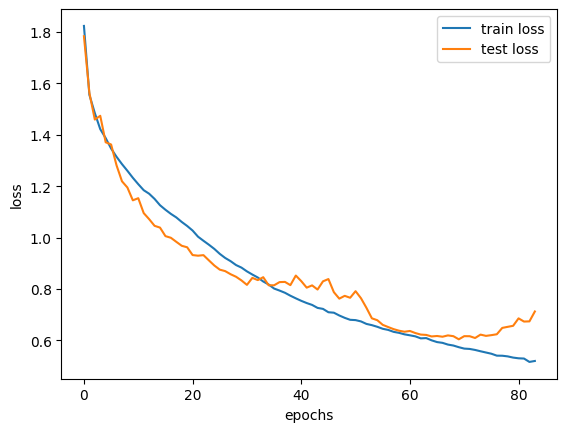

In [32]:
from matplotlib import pyplot as plt
e = range(len(train_cost))
plt.plot(e, train_cost, label = 'train loss')
plt.plot(e, test_cost, label = 'test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

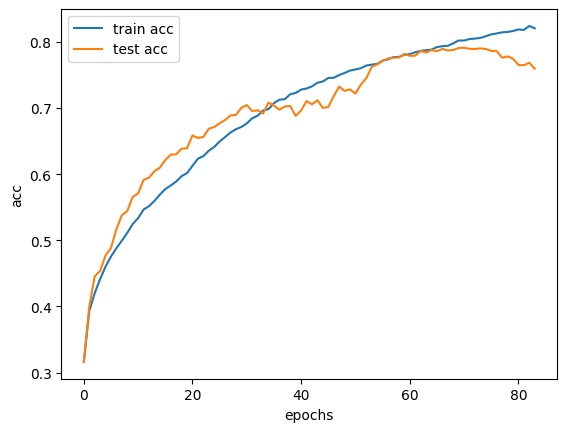

In [34]:
e = range(len(train_cost))
plt.plot(e, train_accuracy, label = 'train acc')
plt.plot(e, test_accuracy, label = 'test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()